In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

In [315]:
# def custom_loss(y_true, y_pred):
#     loss = C*K.mean(K.maximum(0., K.abs(y_true - y_pred) - epsilon))
#     return loss**2

class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_loss", C = 1, epsilon = 0.5, **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)
        self.C = C
        self.epsilon = epsilon

    def call(self, y_true, y_pred):
        y_pred = ops.convert_to_tensor(y_pred)  # 念のためTensor化
        y_true = math_ops.cast(y_true, y_pred.dtype) # 念のため同じデータ型化
        loss = self.C*K.mean(K.maximum(0., K.abs(y_true - y_pred) - self.epsilon))
        return loss**2

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

class SVR(object):
    def __init__(self, epsilon=0.5, C=1):
        self.epsilon = epsilon
        self.C = C
        
    
    def mk_kernel(self, shape, dtype=None): 
        return K.constant(self.W, shape = shape, dtype=dtype)
    
    def mk_bias(self, shape, dtype=None):
        return K.constant(self.b ,shape = shape, dtype=dtype)
    
    def fit(self, X, y, epochs=100, learning_rate=0.1):
        
        feature_len = X.shape[-1] if len(X.shape) > 1 else 1
        
#         self.W = np.array([1.1,2.2,-1.1])
#         self.b = np.array([2.1])
        self.W = np.random.randn(feature_len)
        self.b = np.random.randn(1)
        
        if len(X.shape) == 1:
            self.X = X.reshape(-1, 1)
        else:
            self.X = X
        if len(y.shape) == 1:
            self.y = y.reshape(-1, 1)
        else:
            self.y = y
        
        self.model = keras.Sequential([
            layers.Dense(1, input_shape=[feature_len], kernel_regularizer=keras.regularizers.l2(0), kernel_initializer = self.mk_kernel, bias_initializer = self.mk_bias)
        ])
        
        self.model.compile(loss=CustomLoss(C = self.C, epsilon = self.epsilon), optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False))
        
        # patience は改善が見られるかを監視するエポック数を表すパラメーター
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
        
#         history = model.fit(
#             self.X, self.y,
#             epochs=epochs, validation_split = 0.2, verbose=0,
#             callbacks=[PrintDot()]) 
        print(self.model.layers[0].get_weights()[0])
        print(self.model.layers[0].get_weights()[1])
        self.history = self.model.fit(
            self.X, self.y, validation_split = 0.2,
            epochs=epochs, verbose=0, callbacks=[early_stop, PrintDot()]) 
        
        return self
            
    def predict_(self, X, y=None):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        y_pred = self.model.predict(X)
        return y_pred
    
    def coef_(self):
        result_w = self.model.layers[0].get_weights()[0]
        
        return result_w
    
    def intercept_(self):
        result_b = self.model.layers[0].get_weights()[1]
        
        return result_b
    
    def score(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        y_pred = self.model.predict(X)

        u = ((y_pred - y)**2).sum()
        v = ((y - y.mean())**2).sum()
        R2 = 1 - u/v
        
        return R2

## Sample usage １変数

In [192]:
x = np.linspace(start=0, stop=5, num=20)

In [193]:
x

array([0.        , 0.26315789, 0.52631579, 0.78947368, 1.05263158,
       1.31578947, 1.57894737, 1.84210526, 2.10526316, 2.36842105,
       2.63157895, 2.89473684, 3.15789474, 3.42105263, 3.68421053,
       3.94736842, 4.21052632, 4.47368421, 4.73684211, 5.        ])

In [194]:
m = 2
c = 1

In [195]:
y = m * x + c

In [196]:
y += np.random.normal(size=(len(y),))

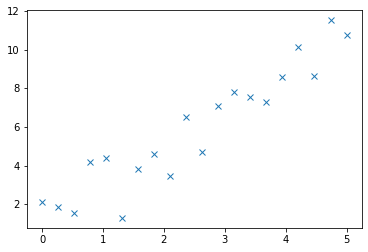

In [197]:
plt.plot(x, y, "x")

In [208]:
model = SVR(epsilon=0.5, C = 1)

In [209]:
model.fit(x, y)

[[-0.48975092]]
[1.5858723]

.........................................

In [210]:
hist = pd.DataFrame(model.history.history)
hist['epoch'] = model.history.epoch
hist

,loss,val_loss,epoch
0,13.797729,97.708252,0
1,11.935796,86.975777,1
2,10.218212,76.914146,2
3,8.641446,67.534119,3
4,7.230017,58.874809,4
5,6.022310,50.939671,5
6,4.971064,43.707100,6
7,4.037422,37.158539,7
8,3.230882,31.316872,8
9,2.600642,26.136322,9


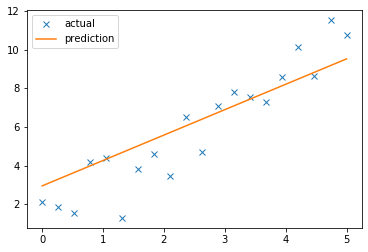

In [211]:
plt.plot(
    x, y, "x",
    x, model.predict(x), "-"
)
plt.legend(["actual", "prediction"])

In [212]:
print(model.coef_())

[[1.3158355]]


In [213]:
print(model.intercept_())

[2.9502268]


## 2変数

In [214]:
x = np.random.rand(1000, 2)  # 20 x 2の配列の乱数

In [215]:
x

array([[0.05732359, 0.46034197],
       [0.23625049, 0.20536293],
       [0.25679326, 0.36933114],
       ...,
       [0.89911442, 0.96054114],
       [0.95705742, 0.1818394 ],
       [0.9457668 , 0.74171871]])

In [216]:
x[:,0]

array([5.73235916e-02, 2.36250486e-01, 2.56793262e-01, 5.29789064e-01,
       3.45474829e-01, 2.45137683e-01, 3.02264467e-02, 8.23310286e-01,
       4.98699248e-01, 4.90182014e-01, 2.81069056e-01, 5.81885069e-01,
       2.47350289e-01, 4.10234436e-01, 2.19490643e-01, 7.59265152e-01,
       2.51343991e-01, 9.58363690e-02, 8.31965002e-01, 8.11234495e-01,
       4.06552430e-01, 3.50825194e-01, 5.72395303e-01, 2.59958927e-02,
       5.90427002e-01, 4.82470307e-01, 6.63338850e-01, 2.01920905e-01,
       7.62137922e-02, 4.33570583e-01, 3.48508212e-01, 6.02580400e-01,
       3.26943513e-01, 5.83458123e-01, 4.39237856e-01, 8.50935319e-01,
       6.61786355e-01, 3.82225172e-01, 3.28331754e-01, 6.92118800e-01,
       7.87349011e-01, 8.89837605e-01, 4.27679104e-01, 7.92548035e-01,
       1.13554200e-02, 7.68510791e-01, 9.81914550e-01, 1.24797537e-01,
       6.90598245e-01, 9.03519621e-02, 6.73797072e-01, 7.97798377e-01,
       2.19884111e-01, 3.08008802e-01, 9.08865374e-01, 6.72353427e-01,
      

In [217]:
x[:,0].reshape(-1,1)

array([[5.73235916e-02],
       [2.36250486e-01],
       [2.56793262e-01],
       [5.29789064e-01],
       [3.45474829e-01],
       [2.45137683e-01],
       [3.02264467e-02],
       [8.23310286e-01],
       [4.98699248e-01],
       [4.90182014e-01],
       [2.81069056e-01],
       [5.81885069e-01],
       [2.47350289e-01],
       [4.10234436e-01],
       [2.19490643e-01],
       [7.59265152e-01],
       [2.51343991e-01],
       [9.58363690e-02],
       [8.31965002e-01],
       [8.11234495e-01],
       [4.06552430e-01],
       [3.50825194e-01],
       [5.72395303e-01],
       [2.59958927e-02],
       [5.90427002e-01],
       [4.82470307e-01],
       [6.63338850e-01],
       [2.01920905e-01],
       [7.62137922e-02],
       [4.33570583e-01],
       [3.48508212e-01],
       [6.02580400e-01],
       [3.26943513e-01],
       [5.83458123e-01],
       [4.39237856e-01],
       [8.50935319e-01],
       [6.61786355e-01],
       [3.82225172e-01],
       [3.28331754e-01],
       [6.92118800e-01],


In [218]:
x = x*10
x

array([[0.57323592, 4.60341968],
       [2.36250486, 2.05362932],
       [2.56793262, 3.69331138],
       ...,
       [8.99114416, 9.60541138],
       [9.57057418, 1.81839404],
       [9.457668  , 7.41718705]])

In [219]:
m = np.array([5, 2])
c = 2

In [220]:
y = np.dot(x, m)+ c

In [221]:
y

array([14.07301894, 17.91978295, 22.22628588, 39.79139823, 26.39108316,
       22.12603816, 17.02433097, 62.71007105, 36.47278708, 45.86486408,
       26.97327955, 50.19592432, 19.05132196, 33.50519743, 32.76558718,
       43.21989003, 31.98606464, 26.50913612, 63.02575709, 54.07440556,
       32.55118611, 33.49266542, 38.31861386, 14.37340641, 31.71552489,
       32.03857837, 53.41190139, 29.1513708 , 17.46426326, 37.28601788,
       36.01208612, 52.09964004, 28.31560455, 32.22151116, 34.67851812,
       46.36558399, 37.81327309, 39.90113543, 27.7625303 , 55.06645284,
       46.05849938, 56.92130705, 27.86902039, 60.28958282,  4.05035088,
       48.60867212, 51.67926408,  9.48190642, 52.16361521, 15.71866593,
       48.73603805, 51.10591891, 14.23184436, 24.93640578, 47.9113124 ,
       47.32515058, 17.8870157 , 37.48542839, 52.900605  , 36.83933746,
       62.91582996, 21.88381064, 29.13581238, 27.15964332, 47.52249962,
       39.58380369, 58.11983469, 37.08976429, 42.9713316 , 55.41

In [222]:
y += np.random.normal(size=(len(y),))

In [223]:
y

array([12.84069384, 17.5356718 , 22.99329065, 39.43360902, 28.34839822,
       21.21549936, 18.81059593, 62.89339549, 37.43051285, 45.10967795,
       26.11716883, 49.99784059, 19.24849893, 33.50229689, 32.89448708,
       42.43203444, 31.83187753, 26.1847956 , 63.95824386, 54.44409857,
       33.57211514, 32.29037299, 38.82187437, 15.25793447, 32.69559997,
       31.08689853, 52.54739285, 30.43570701, 17.29255325, 36.69486663,
       36.8514669 , 51.59274253, 28.12507916, 31.83800591, 35.77654827,
       45.93982288, 37.73120321, 40.42378794, 27.0386152 , 53.66368758,
       46.55352925, 55.19783054, 28.92171365, 60.01566338,  4.12305365,
       47.14413834, 51.92438917, 10.98966309, 52.64992459, 18.0296007 ,
       50.2933597 , 50.10414632, 13.44249335, 23.98596026, 49.19082761,
       46.2911267 , 17.88425448, 38.82096187, 51.67859991, 37.35025293,
       64.1611557 , 22.50978059, 28.37449509, 26.7317755 , 47.86188894,
       38.32318827, 57.90438441, 38.29465972, 42.77504121, 55.52

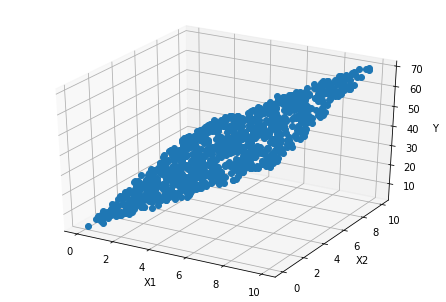

In [224]:
from mpl_toolkits.mplot3d import Axes3D
#グラフの枠を作っていく
fig = plt.figure()
ax = Axes3D(fig)

#軸にラベルを付けたいときは書く
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("Y")

#.plotで描画
#linestyle='None'にしないと初期値では線が引かれるが、3次元の散布図だと大抵ジャマになる
#markerは無難に丸
ax.plot(x[:,0],x[:,1],y,marker="o",linestyle='None')

#最後に.show()を書いてグラフ表示
plt.show()

In [225]:
model = SVR(epsilon=0.2)

In [226]:
model.fit(x, y)

[[-0.71474034]
 [-0.14860399]]
[0.03625185]

............................................................................

In [227]:
model.coef_()

array([[4.9993963],
       [1.9936314]], dtype=float32)

In [228]:
model.intercept_()

array([1.9807003], dtype=float32)

## ボストンの住宅価格予測

In [229]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# データの読み込み
boston = load_boston()

# 訓練データ、テストデータに分割
X, Xtest, y, ytest = train_test_split(boston['data'], boston['target'], test_size=0.2, random_state=114514)
# 6:2:2に分割にするため、訓練データのうちの後ろ1/4を交差検証データとする
# 交差検証データのジェネレーター
def gen_cv():
    m_train = np.floor(len(y)*0.75).astype(int)#このキャストをintにしないと後にハマる
    train_indices = np.arange(m_train)
    test_indices = np.arange(m_train, len(y))
    yield (train_indices, test_indices)
# (それぞれ303 101 102 = サンプル合計は506)
print("リッジ回帰")
print()
print("訓練データ、交差検証データ、テストデータの数 = ", end="")
print(len(next(gen_cv())[0]), len(next(gen_cv())[1]), len(ytest) )
print()

リッジ回帰

訓練データ、交差検証データ、テストデータの数 = 303 101 102



In [230]:
# 訓練データを基準に標準化（平均、標準偏差で標準化）
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
# テストデータも標準化
Xtest_norm = scaler.transform(Xtest)

In [231]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR as SVR_sklearn
from sklearn.model_selection import GridSearchCV

# ハイパーパラメータのチューニング
# 計算に時間がかかるのである程度パラメーターを絞っておいた
# （1e-2～1e4まで12×12でやって最適値が'C': 0.123, 'epsilon': 1.520）
params_cnt = 20
params = {"C":np.logspace(0,1,params_cnt), "epsilon":np.logspace(-1,1,params_cnt)}
gridsearch = GridSearchCV(SVR_sklearn(kernel="linear"), params, cv=gen_cv(), scoring="r2", return_train_score=True)
gridsearch.fit(X_norm, y)
print("C, εのチューニング")
print("最適なパラメーター =", gridsearch.best_params_)
print("精度 =", gridsearch.best_score_)
print()

C, εのチューニング
最適なパラメーター = {'C': 5.455594781168519, 'epsilon': 0.42813323987193935}
精度 = 0.7159704111799641



In [232]:
# チューニングしたハイパーパラメーターをフィット
regr = SVR_sklearn(kernel="linear", C=gridsearch.best_params_["C"], epsilon=gridsearch.best_params_["epsilon"])
train_indices = next(gen_cv())[0]
valid_indices = next(gen_cv())[1]
regr.fit(X_norm[train_indices, :], y[train_indices])
print("切片と係数")
print(regr.intercept_)
print(regr.coef_)
print()
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", regr.score(Xtest_norm, ytest))
print()
print("※参考")
print("訓練データの精度 =", regr.score(X_norm[train_indices, :], y[train_indices]))
print("交差検証データの精度 =", regr.score(X_norm[valid_indices, :], y[valid_indices]))

切片と係数
[21.81552321]
[[-0.92397204  0.86508237  0.21502723  0.41965102 -1.09456985  3.61738556
  -0.57089419 -1.88129657  1.72834405 -1.61423868 -1.76378538  0.72248999
  -2.69561026]]

テストデータにフィット
テストデータの精度 = 0.8340448426009677

※参考
訓練データの精度 = 0.6756997065869174
交差検証データの精度 = 0.7159704111799641


#### Scratchのモデルでもやってみる

In [233]:
C=gridsearch.best_params_["C"]
epsilon=gridsearch.best_params_["epsilon"]

def custom_loss(y_true, y_pred):
    loss = C*K.mean(K.maximum(0., K.abs(y_true - y_pred) - epsilon))
    return loss**2

class CustomLoss(tf.keras.losses.Loss):
    def __init__(self, name="custom_loss", **kwargs):
        super(CustomLoss, self).__init__(name=name, **kwargs)

    def call(self, y_true, y_pred):
        y_pred = ops.convert_to_tensor(y_pred)  # 念のためTensor化
        y_true = math_ops.cast(y_true, y_pred.dtype) # 念のため同じデータ型化
        return custom_loss(y_true, y_pred)

# エポックが終わるごとにドットを一つ出力することで進捗を表示
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

class SVR(object):
    def __init__(self, epsilon=0.5, C=1):
        self.epsilon = epsilon
        self.C = C
        
    def fit(self, X, y, epochs=100, learning_rate=0.1):
        
        feature_len = X.shape[-1] if len(X.shape) > 1 else 1
        
        if len(X.shape) == 1:
            self.X = X.reshape(-1, 1)
        else:
            self.X = X
        if len(y.shape) == 1:
            self.y = y.reshape(-1, 1)
        else:
            self.y = y
        
        self.model = keras.Sequential([
            layers.Dense(1, input_shape=[feature_len], kernel_regularizer=keras.regularizers.l2(0.25))
        ])
        
        self.model.compile(loss=CustomLoss(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False))
        
#         history = model.fit(
#             self.X, self.y,
#             epochs=epochs, validation_split = 0.2, verbose=0,
#             callbacks=[PrintDot()]) 
        
        history = self.model.fit(
            self.X, self.y,
            epochs=epochs, verbose=0,
            callbacks=[PrintDot()]) 
        
        return self
            
    def predict(self, X, y=None):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
            
        y_pred = self.model.predict(X)
        return y_pred
    
    def coef_(self):
        result_w = self.model.layers[0].get_weights()[0]
        
        return result_w
    
    def intercept_(self):
        result_b = self.model.layers[0].get_weights()[1]
        
        return result_b
    
    def score(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        y_pred = self.model.predict(X)

        u = ((y_pred - y)**2).sum()
        v = ((y - y.mean())**2).sum()
        R2 = 1 - u/v
        
        return R2

In [234]:
model = SVR()
model.fit(X_norm[train_indices, :], y[train_indices], epochs = 300)


....................................................................................................
....................................................................................................
....................................................................................................

In [235]:
print("切片と係数")
print(model.intercept_())
print(model.coef_())
print()

切片と係数
[21.931408]
[[-0.63495964]
 [ 0.82971007]
 [ 0.1436613 ]
 [ 0.49799138]
 [-1.0683511 ]
 [ 3.5092008 ]
 [-0.31400418]
 [-1.80079   ]
 [ 1.5859646 ]
 [-1.395214  ]
 [-1.7791195 ]
 [ 0.7507603 ]
 [-3.1162057 ]]



In [236]:
# テストデータの精度を計算
print("テストデータにフィット")
print("テストデータの精度 =", model.score(Xtest_norm, ytest))
print()
print("※参考")
print("訓練データの精度 =", model.score(X_norm[train_indices, :], y[train_indices]))
print("交差検証データの精度 =", model.score(X_norm[valid_indices, :], y[valid_indices]))

テストデータにフィット
テストデータの精度 = 0.8339064850205865

※参考
訓練データの精度 = 0.687611698675909
交差検証データの精度 = 0.6957395616424009


## TeSIAの一部をSVRでやってみる

In [237]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.keras import backend as K
from tensorflow.python.framework import ops
from tensorflow.python.ops import math_ops

print(tf.__version__)

2.1.0


In [238]:
def n_mode_product(x, u, n):# x, uはデータ型がfloat32である必要がある
    n = int(n)
    # We need one letter per dimension
    # (maybe you could find a workaround for this limitation)
    if n > 26:
        raise ValueError('n is too large.')
    ind = ''.join(chr(ord('a') + i) for i in range(n))
    exp = f'{ind}K...,JK->{ind}J...'
    return tf.einsum(exp, x, u)

In [239]:
W_com = np.array([[1], [2], [-1]])
W_eve = np.array([[-1], [1], [1]])
W_sen = np.array([[3], [1], [3]])
b = np.array([2])

In [308]:
X = np.random.rand(10000,3, 3, 3)
X_test = np.random.rand(1000,3, 3, 3)
X

array([[[[0.55727817, 0.86756246, 0.91462601],
         [0.92705321, 0.96367565, 0.13046358],
         [0.72831417, 0.48496094, 0.83106052]],

        [[0.21386706, 0.03621685, 0.08313029],
         [0.9841479 , 0.1519528 , 0.21747191],
         [0.1573733 , 0.33489727, 0.63394105]],

        [[0.69625503, 0.78241571, 0.66308831],
         [0.96895547, 0.25073605, 0.73902635],
         [0.43555888, 0.43661971, 0.21778272]]],


       [[[0.47054237, 0.52719887, 0.34322135],
         [0.33147941, 0.87617669, 0.34483887],
         [0.67679535, 0.97972179, 0.81788257]],

        [[0.98440677, 0.28789957, 0.62581668],
         [0.31832918, 0.74404945, 0.28405769],
         [0.47895595, 0.12876727, 0.56161152]],

        [[0.38237814, 0.35747187, 0.23622392],
         [0.09195718, 0.66451411, 0.20231104],
         [0.44358644, 0.05341948, 0.00133482]]],


       [[[0.95096524, 0.35999524, 0.37335066],
         [0.78673761, 0.91901619, 0.09965345],
         [0.41992252, 0.42122796, 0.13188592

In [309]:
y = (n_mode_product(n_mode_product(n_mode_product(X, W_com.T, 1), W_eve.T, 2), W_sen.T, 3) + b).numpy().reshape(10000,1)
y_test = (n_mode_product(n_mode_product(n_mode_product(X_test, W_com.T, 1), W_eve.T, 2), W_sen.T, 3) + b).numpy().reshape(1000,1)
y

array([[14.18204306],
       [ 8.0443927 ],
       [ 5.82357809],
       ...,
       [15.66259238],
       [ 8.66413697],
       [ 8.97560634]])

In [310]:
X_train = n_mode_product(n_mode_product(X, W_eve.T, 2), W_sen.T, 3)
X_test = n_mode_product(n_mode_product(X_test, W_eve.T, 2), W_sen.T, 3)
X_train

<tf.Tensor: shape=(10000, 3, 1, 1), dtype=float64, numpy=
array([[[[4.01603604]],

        [[5.53844364]],

        [[2.91088027]]],


       [[[5.40039704]],

        [[0.68310982]],

        [[0.72222398]]],


       [[[1.32189971]],

        [[3.29124618]],

        [[4.08081398]]],


       ...,


       [[[2.46166902]],

        [[6.17130049]],

        [[1.14167763]]],


       [[[2.17339995]],

        [[2.550993  ]],

        [[0.61124899]]],


       [[[4.76096691]],

        [[2.58785897]],

        [[2.96107849]]]])>

In [311]:
X_train = tf.reshape(X_train, [10000, 3])
X_test = tf.reshape(X_test, [1000, 3])
X_train

<tf.Tensor: shape=(10000, 3), dtype=float64, numpy=
array([[4.01603604, 5.53844364, 2.91088027],
       [5.40039704, 0.68310982, 0.72222398],
       [1.32189971, 3.29124618, 4.08081398],
       ...,
       [2.46166902, 6.17130049, 1.14167763],
       [2.17339995, 2.550993  , 0.61124899],
       [4.76096691, 2.58785897, 2.96107849]])>

In [312]:
model = SVR(C=0.000001)
model.fit(X_train, y, epochs = 100)

[[ 1.1]
 [ 2.2]
 [-1.1]]
[2.1]

....................................................................................................

In [316]:
result = pd.DataFrame(index = ['coef_1', 'coef_2', 'coef_3', 'int', 'test_score'])
for c in [10000, 1000, 100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001, 0.0000001, 0.00000001, 0.000000001, 0.0000000001]:
    model = SVR(C=c)
    model.fit(X_train, y, epochs = 100)
    result[str(c)] = model.coef_().reshape(1,3).tolist()[0] + model.intercept_().tolist() + [model.score(X_test, y_test)]

[[ 1.1900357 ]
 [-0.8928176 ]
 [-0.80607295]]
[-1.0864972]

.......................................................................................[[-0.37977096]
 [ 0.3901067 ]
 [-0.36207762]]
[-0.10973162]

.....................................................................................[[-0.05925776]
 [ 0.15229586]
 [-0.78327304]]
[-1.7576321]

................................................................................[[0.88226444]
 [0.54404974]
 [0.5097505 ]]
[-1.461557]

...............................................................................[[ 0.44704986]
 [-0.96286124]
 [ 0.7922485 ]]
[-0.68716085]

............................................................................[[-0.59260225]
 [-0.6671219 ]
 [ 0.30530939]]
[0.18792227]

.........................................................[[ 0.8340154 ]
 [-0.44509473]
 [ 0.24352174]]
[-1.8077289]

............................................................................................[[ 1.2069542]
 [ 0.2940754

In [317]:
result

,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,1e-05,1e-06,1e-07,1e-08,1e-09,1e-10
coef_1,1.023494,1.022673,1.021499,1.025127,1.023464,1.031510,1.021438,1.022914,1.014831,1.173057,0.356088,0.261717,-0.596364,0.859696,-0.542903
coef_2,2.045859,2.045121,2.042388,2.046087,2.045861,2.017637,2.044128,2.033437,1.986961,2.163934,0.633597,-1.080737,-0.473871,-0.031812,-0.092682
coef_3,-0.977313,-0.977371,-0.978880,-0.974174,-0.976472,-0.946777,-0.977357,-0.979268,-0.924671,-0.832524,1.360649,1.110694,-0.372952,0.197603,0.845307
int,1.553651,1.552333,1.549368,1.560439,1.554618,1.616622,1.550422,1.518677,1.713083,0.008602,0.036607,-1.470637,0.502246,-0.583788,1.003921
test_score,0.998941,0.998896,0.998738,0.999092,0.998968,0.999343,0.998828,0.998107,0.999056,0.984742,-0.281747,-4.396160,-6.704543,-1.129028,-2.459598


In [314]:
result

,10000,1000,100,10,1,0.1,0.01,0.001,0.0001,1e-05,1e-06,1e-07,1e-08,1e-09,1e-10
coef_1,1.019653,0.982086,0.993790,0.980223,0.987127,0.989027,0.977147,0.978428,1.008441,1.014369,1.068533,1.100000,1.100000,1.100000,1.100000
coef_2,1.982382,1.963581,1.957292,1.977847,1.985248,1.984651,1.960233,1.954647,2.036116,2.070718,2.163116,2.200000,2.200000,2.200000,2.200000
coef_3,-0.967123,-0.991211,-0.957182,-0.953570,-0.961380,-0.988183,-0.975417,-0.983365,-1.064991,-1.105024,-1.121178,-1.100000,-1.100000,-1.100000,-1.100000
int,2.046813,1.972946,2.040533,2.051706,2.019360,2.027811,2.013943,2.059855,2.078797,2.080727,2.092089,2.100000,2.100000,2.100000,2.100000
test_score,0.998746,0.998540,0.999385,0.999353,0.999585,0.999900,0.999074,0.999084,0.999105,0.997388,0.984695,0.968458,0.968458,0.968458,0.968458


In [269]:
print("切片と係数")
print(model.intercept_())
print(model.coef_())
print()

切片と係数
[2.09588]
[[ 0.95076627]
 [ 1.9094968 ]
 [-0.98039436]]



In [282]:
model.intercept_().tolist()

[8.914908409118652]

In [265]:
print(model.score(X_train, y))
print(model.score(X_test, y_test))

-12579.987011634777
-1254.611752711046


In [260]:
model.predict(X_train)

array([[11.96965  ],
       [ 5.6707897],
       [10.376173 ],
       ...,
       [ 2.7423131],
       [10.226514 ],
       [11.029329 ]], dtype=float32)

In [261]:
y

array([[[[16.1371338 ]]],


       [[[ 4.0563879 ]]],


       [[[ 7.12615531]]],


       ...,


       [[[-1.35602981]]],


       [[[13.61480818]]],


       [[[17.02842695]]]])

In [296]:
model.predict_(X_train)

array([[17.650848 ],
       [ 4.3620267],
       [ 7.738771 ],
       ...,
       [-1.5916331],
       [14.876289 ],
       [18.631271 ]], dtype=float32)

In [305]:
model.model.predict(X_train) - y.reshape(10000,1)

array([[ 1.51371459],
       [ 0.30563879],
       [ 0.61261565],
       ...,
       [-0.23560327],
       [ 1.26148119],
       [ 1.60284441]])

In [304]:
y.reshape(10000,1)

array([[16.1371338 ],
       [ 4.0563879 ],
       [ 7.12615531],
       ...,
       [-1.35602981],
       [13.61480818],
       [17.02842695]])

In [ ]:
def score(self, X, y):
        if len(X.shape) == 1:
            X = X.reshape(-1, 1)
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
        
        y_pred = self.model.predict(X)

        u = ((y_pred - y)**2).sum()
        v = ((y - y.mean())**2).sum()
        R2 = 1 - u/v